In [1]:
import os, sys, time
import espressomd, espressomd.lb
import numpy as np
#from numpy.fft import fftn,fftfreq
import matplotlib.pyplot as plt
import itertools as it
import scipy.signal
import statsmodels.tsa.stattools as stattools

In [2]:
### Parameters ###
dim = 3
dx = 1 # agrid
dt = 1 # timestep
rho = 1 # density
tau = 0.75
nu = 1/3*(tau-0.5) # viscosity
L = 64 # side length
kT = 1e-6/9 #test['T'] #2.464*10**(-7)
################

### Setup ###
system = espressomd.System(box_l=[L]*3)
system.time_step = 1
system.cell_system.skin = 0.0

lbfluid = espressomd.lb.LBFluid(agrid = dx, tau = dt, dens = rho, visc = nu, kT = kT, seed=134)
system.actors.add(lbfluid)
print(lbfluid.get_params())
uid = np.random.randint(0, 1001)
###############

{'agrid': 1.0, 'dens': 1.0, 'ext_force_density': array([0., 0., 0.]), 'visc': 0.08333333333333333, 'bulk_visc': -1.0, 'tau': 1.0, 'seed': 134, 'kT': 1.1111111111111111e-07}


In [3]:
# rolling autocorrelation as implemented in LBMeX (adopted from DSMCgran)
def update_autocorrelation(acf, data, x):
    data = np.roll(data,1,axis=0)
    data[0] = x
    acf += x*data
    return acf, data

In [4]:
nsteps = 15
ncorr = 5

Pdata = np.zeros((ncorr,L,L,L,3,3))
Pacf = np.zeros((ncorr,L,L,L,3,3))
allPeq = []
allPneq = []

### Time Loop ###
start = time.time()
for i in range(nsteps):
    system.integrator.run(steps = 1)

    lbf = lbfluid[:, :, :]
    Peq = lbf.pressure_tensor
    Pneq = lbf.pressure_tensor_neq
    allPeq.append(Peq)
    allPneq.append(Pneq)
    
    P = Peq + Pneq
    Pacf, Pdata = update_autocorrelation(Pacf, Pdata, P)
    
    current_time = time.strftime("%H:%M:%S", time.localtime())
    print(current_time, ': Timestep ', i+1, end='\r')
print()
end = time.time()
print('{0} Timesteps run in {1:.3f}s, average of {2:.3f} s/timesteps'.format(nsteps, end - start, (end - start)/nsteps))
#################

12:35:33 : Timestep  15
15 Timesteps run in 69.343s, average of 4.623 s/timesteps


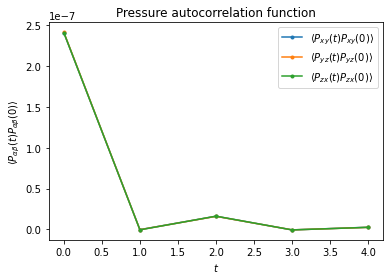

In [5]:
for i in range(3):
    pacf = Pacf.mean(axis=(1,2,3)).T[i,(i+1)%3]
    plt.plot(pacf,'.-',label=r'$\langle P_{%c%c}(t) P_{%c%c}(0) \rangle$'%tuple([120+i,120+(i+1)%3]*2))
plt.legend()
plt.title('Pressure autocorrelation function')
plt.xlabel('$t$')
plt.ylabel(r'$\langle P_{\alpha\beta}(t) P_{\alpha\beta}(0) \rangle$')
plt.show()

In [6]:
nu = np.mean([Pacf.mean(axis=(1,2,3)).T[i,(i+1)%3].sum() for i in range(3) ])
nu /= kT
print("Viscosity at tau =",tau,"\b: nu =",nu)

Viscosity at tau = 0.75 : nu = 2.3328919345191483


Pressure autocorrelation:
\begin{equation}
ACF(t') = \left\langle P(t')P(0) \right\rangle = \frac{1}{N_t-t'}\sum_{t=0}^{N_t} P(t+t')P(t)
\end{equation}
(note the denominator $N_t-t'$ for unbiased autocovariance)

Running calculation as implemented in LBMeX (adopted from DSMCGran):
$$ACF(t') = \sum_{t=0}^{N_t} P(t)P(t-t')$$
(note normalization is dropped for now)

`scipy.signal.correlate` computes:
\begin{equation}
z(k) = (x*y)(k-N+1) = \sum_{l=0}^{n_x-1}x_ly^*_{l-k+N-1} \qquad N=\max(n_x,n_y) \quad k=0,1,\dots,n_x+n_y-2
\end{equation}
(note the shifted lag)

In [7]:
ncorr = 5
P = np.array(allPeq) + np.array(allPneq)
P -= np.mean(P,axis=0) # center data for comparison with statsmodels acf
p = P[:,0,0,0,1,2]

In [8]:
%%time
x = p
data = np.zeros((ncorr,*x.shape[1:]))
acf = np.zeros((ncorr,*x.shape[1:]))
for t in range(nsteps):
    acf, data = update_autocorrelation(acf, data, x[t])
ps = acf

CPU times: user 2.07 ms, sys: 12 µs, total: 2.08 ms
Wall time: 2.42 ms


In [9]:
%%time
ac_numpy = np.correlate(p,p,mode='fft')[len(p)-1:][:ncorr]

CPU times: user 217 µs, sys: 5 µs, total: 222 µs
Wall time: 190 µs


In [10]:
%%time
ac_scipy = scipy.signal.correlate(p,np.concatenate([[0]*(len(p)-1),p]),mode='valid')[:ncorr]

CPU times: user 177 µs, sys: 4 µs, total: 181 µs
Wall time: 172 µs


In [11]:
%%time
ac_sm = stattools.acf(p)[:ncorr]

CPU times: user 890 µs, sys: 0 ns, total: 890 µs
Wall time: 923 µs


In [12]:
%%time
# rolling acf (note that the average acf of the windows is _not_ equal to the acf of the full series)
v = p
data = np.zeros((ncorr, *v.shape[1:]))
acf = np.zeros((ncorr, *v.shape[1:]))
for t in range(nsteps+ncorr):
    data = np.roll(data,-1,axis=0)
    data[-1] = v[t] if t<nsteps else 0
    for idx in it.product(*map(range,v.shape[1:])):
        s = data if idx==() else data[:,idx]
        acf += scipy.signal.correlate(s,s)[len(s)-1:]
ac = acf/np.arange(ncorr,0,-1)

CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 2.17 ms


In [13]:
assert(np.allclose(ps,ac))
assert(np.allclose(ps,ac_numpy))
assert(np.allclose(ps,ac_scipy))
assert(np.allclose(ps/ps[0],ac_sm)) # normalize zero lag correlation for comparison with statsmodels acf

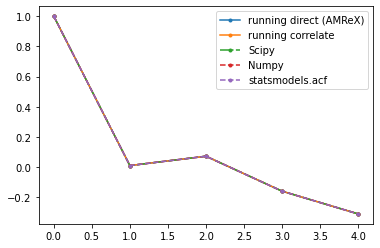

In [14]:
plt.plot(ps/ps[0],'.-',label='running direct (AMReX)')
plt.plot(ac/ac[0],'.-',label='running correlate')
plt.plot(ac_scipy/ac_scipy[0],'.-.',label='Scipy')
plt.plot(ac_numpy/ac_numpy[0],'.--',label='Numpy')
plt.plot(ac_sm,'.--',label='statsmodels.acf')
plt.legend()
plt.show()